Predicted: tench ( 0.9962168335914612 )


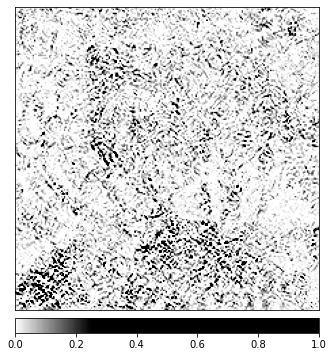

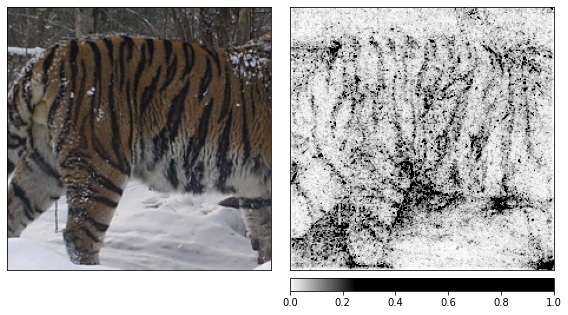

In [13]:
%matplotlib inline

import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
import antialiased_cnns

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
# model = models.resnet18(pretrained=True)
# model_path = 'tigers_bbox/trained_models/resnet50/weights_epoch_77.h5'


# model_path = 'trained_models/resnet152/weights_epoch_75.h5'

model_path = 'trained_models/resnet50/weights_epoch_70.h5'

model = antialiased_cnns.resnet50(pretrained=True)
model.fc = torch.nn.Sequential(
               torch.nn.Linear(2048, 128),
               torch.nn.ReLU(inplace=True),
               torch.nn.Linear(128, 2))
model.load_state_dict(torch.load(model_path))
model.eval()

for param in model.parameters():
    param.requires_grad = False
model._modules.get('avgpool')
model = model.eval()


# !wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json


labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )


def vis_img(img):
    transformed_img = transform(img)

    input = transform_normalize(transformed_img)
    input = input.unsqueeze(0)

    output = model(input)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                     [(0, '#ffffff'),
                                                      (0.25, '#000000'),
                                                      (1, '#000000')], N=256)

    _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap=default_cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1)

    noise_tunnel = NoiseTunnel(integrated_gradients)

    attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          cmap=default_cmap,
                                          show_colorbar=True)
    
    
# img = Image.open('data/cropped/Тигры/001_1001.jpg')
img = Image.open('data/cropped/Тигры/001_1002.jpg')
vis_img(img)